# Исследование пользовательского спроса сервиса «Яндекс Афиша»

## Цель и задачи  

**Цель:** Провести исследовательский анализ данных сервиса Яндекс.Афиша за период с 1 июня по 30 октября 2024 года, выявив основные тенденции, касающиеся поведения пользователей, популярных событий и эффективности взаимодействия с сервисом бронирования билетов.   

**Задачи:**
1. Знакомство с данными и их предварительная обработка:
2. Исследовательский анализ данных:
    - изучение динамики количества заказов по сезонам и устройствам;
    - определение влияния возраста аудитории и устройства на поведение пользователей;
    - исследование популярности различных видов мероприятий и площадок осенью 2024 года;
3. Тестирование гипотез:
    - формулировка и проверка гипотез о различиях в активности пользователей мобильных и стационарных устройств;
    - выбор подходящего метода тестирования и интерпретация полученных результатов;
4. Подготовка вывода и рекомендаций:
    - подведение итогов проведённого анализа;
    - предоставление предложений по дальнейшему развитию продукта и улучшению показателей сервиса.

## Данные

Для анализа предоставлены данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Данные состоят из трех датасетов:

- `final_tickets_orders_df` — информация обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных;
- `final_tickets_events_df` —  информация о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия;
- `final_tickets_tenge_df` — информация о курсе тенге к российскому рублю за 2024 год.

### Описание датасета `final_tickets_orders_df`

<br>`order_id` — уникальный идентификатор заказа.
<br>`user_id` — уникальный идентификатор пользователя.
<br>`created_dt_msk` — дата создания заказа (московское время).
<br>`created_ts_msk` — дата и время создания заказа (московское время).
<br>`event_id` — идентификатор мероприятия из таблицы events.
<br>`cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
<br>`age_limit` — возрастное ограничение мероприятия.
<br>`currency_code` — валюта оплаты, например rub для российских рублей.
<br>`device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
<br>`revenue` — выручка от заказа.
<br>`service_name` — название билетного оператора.
<br>`tickets_count` — количество купленных билетов.
<br>`total` — общая сумма заказа.

### Описание датасета `final_tickets_events_df`

<br>`event_id` — уникальный идентификатор мероприятия;
<br>`event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных;
<br>`event_type_description` — описание типа мероприятия;
<br>`event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее;
<br>`organizers` — организаторы мероприятия;
<br>`region_name` — название региона;
<br>`city_name` — название города;
<br>`venue_id` — уникальный идентификатор площадки;
<br>`venue_name` — название площадки;
<br>`venue_address` — адрес площадки.

### Описание датасета `final_tickets_tenge_df`

<br>`nominal` — номинал (100 тенге);
<br>`data` — дата;
<br>`curs` — курс тенге к рублю;
<br>`cdx` — обозначение валюты (kzt).

## Структура проекта

1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Общий вывод и рекомендации

##  Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

In [2]:
# Выгружаем данные в переменные
orders_df = pd.read_csv(r'D:\pr_git_hub\yandex_afisha\final_tickets_orders_df.csv')
events_df = pd.read_csv(r'D:\pr_git_hub\yandex_afisha\final_tickets_events_df.csv')
tenge_df = pd.read_csv(r'D:\pr_git_hub\yandex_afisha\final_tickets_tenge_df.csv')

Познакомимся с данными датасета `orders_df` — выведем первые строки и общую информацию:

In [3]:
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Датасет `orders_df` содержит 290 849 строк и 14 столбцов. Содержание данных соответствует описанию.

В датасете отмечено:

* пропуски содержатся только в столбце `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя. Пропуски обоснованы ТЗ: предыдущей покупки не было;
* столбцы `order_id`, `event_id`  необходимо привести к строковому значению;
* столбцы `created_dt_msk` и `created_ts_msk` к формату даты;
* столбцы `age_limit` и `tickets_count` необходимо оптимизировать с понижением размерности;
* столбец `days_since_prev` привести к целочисленному типу (предварительно заменив пропуски на 0).

Познакомимся с данными датасета `events_df` — выведем первые строки и общую информацию:

In [5]:
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Датасет `events_df` содержит 22 427 строк и 11 столбцов. Содержание данных соответствует описанию.

В датасете отмечено:

* во ввсем датасете отсутствуют пропуски;
* столбцы `event_id`, `city_id` и `venue_id` необходимо привести к строковому значению;
* в столбце `organizers` необходимо убрать "№" в начале каждой строки для корректного восприятия данных.

Познакомимся с данными датасета `tenge_df` — выведем первые строки и общую информацию:

In [7]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датасет `tenge_df` содержит 357 строк и 4 столбцf. Содержание данных соответствует описанию.

В датасете отмечено:

* во всем датасете отсутствуют пропуски;
* столбец `data` необходимо привести к формату даты;
* столбец `nominal` необходимо оптимизировать с понижением размерности.

Первичное знакомство показывает, что данные хорошего качества — в них практически нет пропущенных значений, а сами данные соответствуют описанию и выглядят корректными.

## Предобработка данных и подготовка их к исследованию

### Работа с типами данных

Выполним необходимые преобразования типов данных, отмеченных ранее:

In [9]:
# Преобразования для датафрейма orders_df
orders_df['order_id'] = orders_df['order_id'].astype(str)
orders_df['event_id'] = orders_df['event_id'].astype(str)
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])
orders_df['days_since_prev'] = orders_df['days_since_prev'].fillna(0).astype('int')  # Заменяем пропуски на 0 и приводим к Int64
orders_df['age_limit'] = pd.to_numeric(orders_df['age_limit'], downcast='integer')
orders_df['tickets_count'] = pd.to_numeric(orders_df['tickets_count'], downcast='integer')

# Преобразования для датафрема events_df
events_df['event_id'] = events_df['event_id'].astype(str)
events_df['city_id'] = events_df['city_id'].astype(str)
events_df['venue_id'] = events_df['venue_id'].astype(str)
events_df['organizers'] = events_df['organizers'].apply(lambda x: x.replace('№', ''))  # Убираем символ №

# Преобразования для датафрейма tenge_df
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
tenge_df['nominal'] = pd.to_numeric(tenge_df['nominal'], downcast='integer')

Убедимся, что типы преобразованы корректно:

In [10]:
orders_df.dtypes

order_id                         object
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                         object
cinema_circuit                   object
age_limit                          int8
currency_code                    object
device_type_canonical            object
revenue                         float64
service_name                     object
tickets_count                      int8
total                           float64
days_since_prev                   int32
dtype: object

In [11]:
events_df.dtypes

event_id                  object
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                   object
venue_id                  object
venue_name                object
venue_address             object
dtype: object

In [12]:
tenge_df.dtypes

data       datetime64[ns]
nominal              int8
curs              float64
cdx                object
dtype: object

### Изучение значений в ключевых столбцах

#### Категориальные значения:

Изучим, какие категории присутствуют в данных:

In [13]:
# Функция для изучения уникальных значений выбранных столбцов
def explore_and_clean(df, categorical_columns):
    for col in categorical_columns:
        print(f"{col}: {df[col].unique()}\n")

In [14]:
explore_and_clean(orders_df, ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name'])

cinema_circuit: ['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']

age_limit: [16  0 18 12  6]

currency_code: ['rub' 'kzt']

device_type_canonical: ['mobile' 'desktop']

service_name: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']



In [15]:
explore_and_clean(events_df, ['event_type_description', 'event_type_main'])

event_type_description: ['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']

event_type_main: ['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']



In [16]:
explore_and_clean(tenge_df, ['cdx'])

cdx: ['kzt']



**Датафрейм `orders_df`**
<br> Столбец `cinema_circuit`
<br> Уникальные значения:

* нет
* Другое
* Киномакс
* КиноСити
* Москино
* ЦентрФильм

Категория представляет 4 крупные сети кинотеатров.  Если не применимо, стоит значение 'нет'. Так же есть значение 'другое', вероятно это также означает, что мероприятие не относится к кинтеатрам, можно заменить на 'нет'.

Столбец `age_limit`
<br>Уникальные значения:

* 16
* 0
* 18
* 12
* 6

Этот столбец отражает возрастные ограничения мероприятий. Мероприятия распределены по нескольким категориям возрастных групп.

Столбец `currency_code`
<br>Уникальные значения:

* rub
* kzt

Валюта представлена двумя единицами измерения: российские рубли (rub) и казахстанские тенге (kzt).

Столбец `device_type_canonical`
<br>Уникальные значения:

* mobile
* desktop

Тип устройства представлен двумя вариантами: мобильные устройства (mobile) и настольные ПК (desktop). Такое разделение полезно для понимания предпочтений пользователей и их поведенческих особенностей.

Столбец `service_name`

Здесь содержится множество уникальных наименований операторов билетов.

**Датафрейм `events_df`**

Столбец `event_type_description`

Данный столбец содержит детализированные описания типа мероприятия, что позволит проводить глубокий сегментированный анализ событий. Важно отметить высокую вариативность, отражающую широкий спектр мероприятий, представленных в данных.

Столбец `event_type_main`

Эта классификация помогает структурировать и обобщить виды мероприятий, позволяя строить выводы на уровне крупных сегментов рынка развлечений (например, театр, концерты, выставки).

Заменим в столбце `orders_df['cinema_circuit']` значение 'Другое' на 'нет':

In [17]:
orders_df['cinema_circuit'] = orders_df['cinema_circuit'].replace('Другое', 'нет')

Проверим, встречаются ли значения, которые могут обозначать пропуски в данных или отсутствие информации:

In [18]:
# функция проверки столюцов датафрейма на включение наиболее часто встречающихся значений, которыми обозначают пропуски
def check_missing_values(df, categorical_columns): 
    possible_missing_values = ['NA', 'Unknown', 'None', 'none', 'nan', 'Nan', 'Отсутствует', 'Не определено']
    
    missing_value_checks = {}  # Хранит информацию о пропусках

    for column in categorical_columns:
        column_checks = []  # Временный список для текущего столбца
        for value in possible_missing_values:
            count = sum(df[column] == value)  # Подсчет количества совпадений
            if count > 0:
                column_checks.append((value, count))  # Сохраняем пару (значение, количество)
        
        if column_checks:
            missing_value_checks[column] = column_checks  # Добавляем в общий словарь
    
    return missing_value_checks

In [19]:
# Выполняем проверку:
result = check_missing_values(orders_df, ['order_id', 'user_id', 'event_id', 'cinema_circuit',])

# Выводим результат:
if result:
    print("Потенциальные пропуски в данных:")
    for col, checks in result.items():
        print(f"Столбец {col}:")
        for value, count in checks:
            print(f"- Значение '{value}' встречается {count} раз.")
else:
    print("Ни одно из указанных значений не найдено в данных.")

Ни одно из указанных значений не найдено в данных.


In [20]:
# Выполняем проверку:
result = check_missing_values(events_df, ['event_id', 'event_name', 'organizers', 'region_name', 'city_name', 'venue_id', 'venue_name', 'venue_address'])

# Выводим результат:
if result:
    print("Потенциальные пропуски в данных:")
    for col, checks in result.items():
        print(f"Столбец {col}:")
        for value, count in checks:
            print(f"- Значение '{value}' встречается {count} раз.")
else:
    print("Ни одно из указанных значений не найдено в данных.")

Ни одно из указанных значений не найдено в данных.


Значения, которые могут обозначать пропуски в данных или отсутствие информации, в датафреймах отсутствуют.

#### Количественные значения

Проверим данные на аномалии и выбросы, разделив на два датафрейма по валютам в rub и kzt:

In [21]:
rub_df = orders_df[orders_df['currency_code'] == 'rub']
kzt_df = orders_df[orders_df['currency_code'] == 'kzt']

**Анализ распределения выручки**

Анализ распределения выручки в рублях:

In [22]:
rub_df['revenue'].describe()

count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

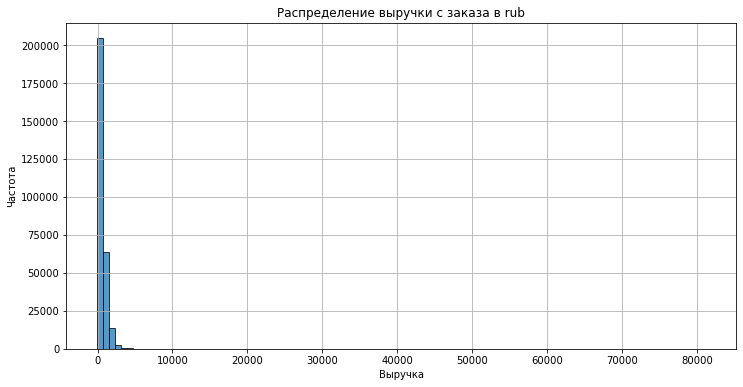

In [23]:
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
rub_df['revenue'].plot(
    kind='hist',    # Тип графика — гистограмма
    bins=100,        # Устанавливаем количество корзин
    alpha=0.75,     # Прозрачность заполнения
    edgecolor='black',  # Цвет границ столбцов
)

# Настраиваем оформление графика
plt.title('Распределение выручки с заказа в rub')
plt.xlabel('Выручка')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

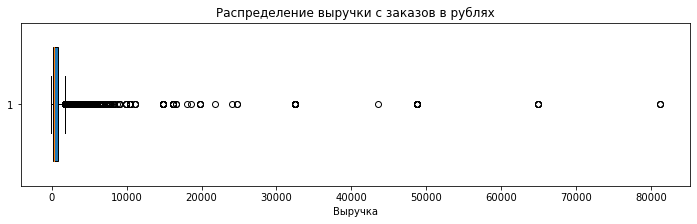

In [24]:
plt.figure(figsize=(12, 3))

# Строим boxplot
plt.boxplot(rub_df['revenue'], vert=False, widths=0.7, patch_artist=True)

# Оформляем график
plt.title('Распределение выручки с заказов в рублях')
plt.xlabel('Выручка')

# Выводим график
plt.show()

**Минимальное значение (-90.76):** отрицательные значения - возврат денежных средств.

**Стандартное отклонение (871.52):** высокое стандартное отклонение свидетельствует о большой дисперсии данных, то есть существует значительное разброс значений вокруг среднего. Это значит, что большая часть доходов сильно отличается от средней величины.

**Медиана и среднее (346.10 против 547.57):** наличие большого количества экстремально высоких значений (выбросы) смещает среднее вверх, тогда как медиана остаётся более устойчивой к влиянию выбросов. Следовательно, распределение имеет сильное правостороннее смещение (правый хвост), что наглядно видно на диаграмме.

**Максимальное значение (81174.54):** очень высокое максимальное значение свидетельствует о присутствии выбросов, возможно обусловленных крупными покупками или специальными случаями. Чтобы результаты анализы не были искажены выбросами, такие значения необходимо удалить

**25-й и 75-й процентили (113.83 и 791.70 соответственно)**: между первым и третьим квартилями наблюдается значительный диапазон (почти 7-кратный разрыв), что подтверждает неравномерность распределения выручки.

Анализ распределения выручки в тенге:

In [25]:
kzt_df['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

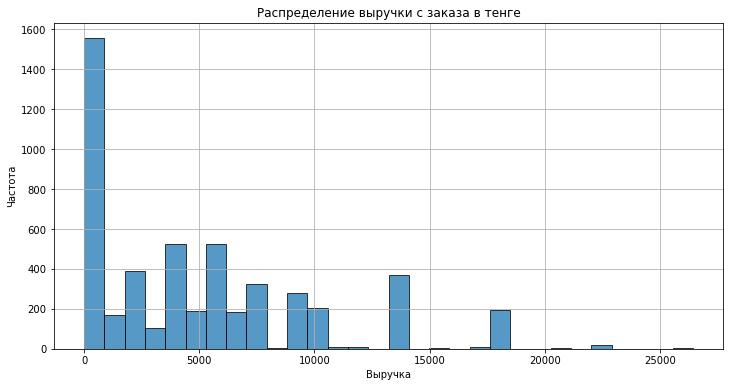

In [26]:
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
kzt_df['revenue'].plot(
    kind='hist',    # Тип графика — гистограмма
    bins=30,        # Устанавливаем количество корзин
    alpha=0.75,     # Прозрачность заполнения
    edgecolor='black',  # Цвет границ столбцов
)

# Настраиваем оформление графика
plt.title('Распределение выручки с заказа в тенге')
plt.xlabel('Выручка')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

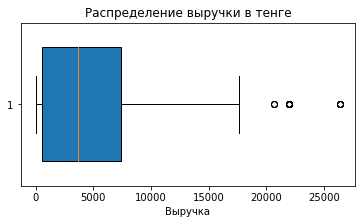

In [27]:
plt.figure(figsize=(6, 3))

# Строим boxplot
plt.boxplot(kzt_df['revenue'], vert=False, widths=0.7, patch_artist=True)

# Оформляем график
plt.title('Распределение выручки в тенге')
plt.xlabel('Выручка')

# Выводим график
plt.show()

**Минимальное значение (0):** отсутствие минимальной выручки говорит об отсутствии возвратов.

**Стандартное отклонение (4916.75):** высокое стандартное отклонение свидетельствует о значительной дисперсии данных, то есть наблюдается большой разброс значений вокруг среднего.

**Медиана и среднее (3698.83 против 4995.21):** завышенное среднее обусловлено влиянием крупных заказов. Таким образом, распределение смещено вправо, что заметно на графике.

**Максимальное значение (26425.86):** Высокая максимальная выручка говорит о наличии крупных заказов. Чтобы снизить влияние аномально крупных сделок на анализ, их необходимо удалить.

**25-й и 75-й процентили (518.10 и 7397.66 соответственно):** значительный разрыв между первыми и третьими квартилями (более 14-кратное увеличение), что подтверждает неравномерность распределения выручки.

**Анализ распределения количества билетов**

Анализ распределния количества билетов в заказе для заказов в рублях:

In [28]:
rub_df['tickets_count'].describe()

count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

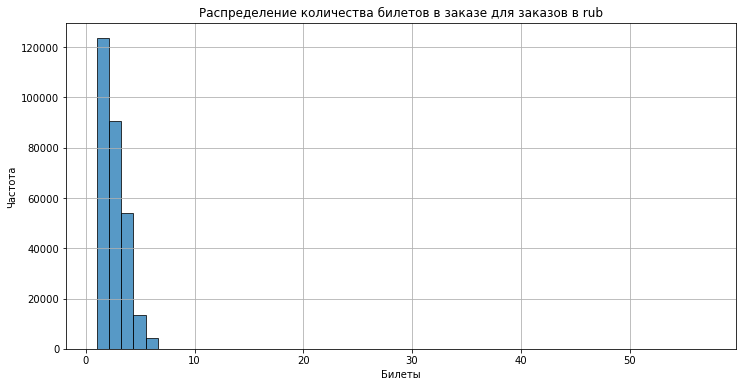

In [29]:
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
rub_df['tickets_count'].plot(
    kind='hist',    # Тип графика — гистограмма
    bins=50,        # Устанавливаем количество корзин
    alpha=0.75,     # Прозрачность заполнения
    edgecolor='black',  # Цвет границ столбцов
)

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе для заказов в rub')
plt.xlabel('Билеты')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

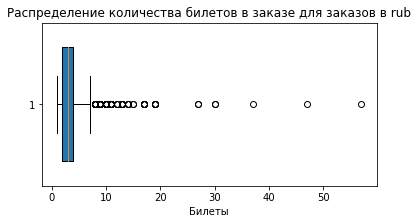

In [30]:
plt.figure(figsize=(6, 3))

# Строим boxplot
plt.boxplot(rub_df['tickets_count'], vert=False, widths=0.7, patch_artist=True)

# Оформляем график
plt.title('Распределение количества билетов в заказе для заказов в rub')
plt.xlabel('Билеты')

# Выводим график
plt.show()

**Минимальное значение (1)**: минимальное количество билетов в одном заказе равно одному, что является естественным ограничением снизу.

**Среднее значение (2.75):** средний размер заказа составляет примерно три билета, что отражает умеренный уровень потребления.

**Стандартное отклонение (1.17):** относительно низкое стандартное отклонение указывает на небольшой разброс количества билетов в большинстве заказов.

**Медиана (3):** половина всех заказов содержит ровно три билета, что совпадает со средним значением и демонстрирует симметричность распределения.

**25-й и 75-й процентили (2 и 4 соответственно):** основная масса заказов включает два-четыре билета, показывая узкий диапазон типичных размеров заказов.

**Максимальное значение (57):** наличие крайне редких больших заказов, содержащих значительное число билетов, вероятно, являются исключениями и случаями, когда билеты заказываются для больших компаний.

Анализ распределния количества билетов в заказе для заказов в тенге:

In [31]:
kzt_df['tickets_count'].describe()

count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64

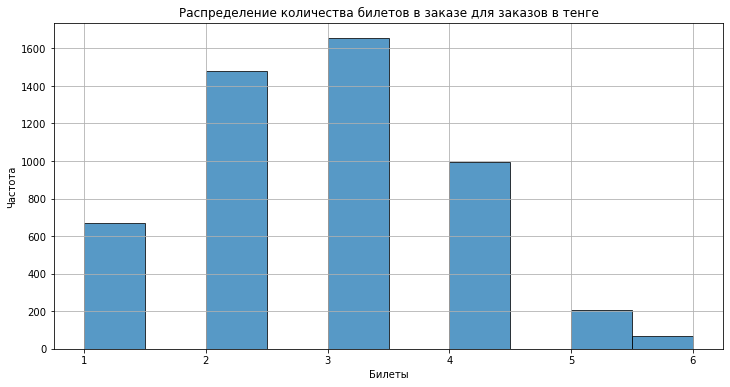

In [32]:
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
kzt_df['tickets_count'].plot(
    kind='hist',    # Тип графика — гистограмма
    bins=10,        # Устанавливаем количество корзин
    alpha=0.75,     # Прозрачность заполнения
    edgecolor='black',  # Цвет границ столбцов
)

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе для заказов в тенге')
plt.xlabel('Билеты')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

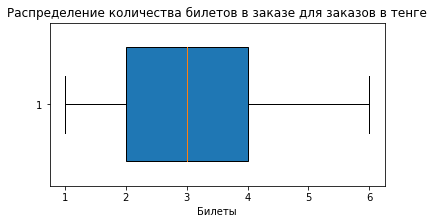

In [33]:
plt.figure(figsize=(6, 3))

# Строим boxplot
plt.boxplot(kzt_df['tickets_count'], vert=False, widths=0.7, patch_artist=True)

# Оформляем график
plt.title('Распределение количества билетов в заказе для заказов в тенге')
plt.xlabel('Билеты')

# Выводим график
plt.show()

**Минимальное значение (1):** минимальное количество билетов в одном заказе также начинается с единицы, что соответствует ожиданиям.

**Среднее значение (2.76):** средняя величина числа билетов близка к значию в рублях, составляя примерно три билета на заказ.

**Стандартное отклонение (1.12):** относительно низкое стандартное отклонение указывает на небольшой разброс количества билетов в большинстве заказов.

**Медиана (3):** медианный также равна трем билетам, что согласуется со средним показателем.

**25-й и 75-й процентили (2 и 4 соответственно):** подавляющее большинство заказов укладывается в рамки от двух до четырех билетов.

**Максимальное значение (6):** наибольший зарегистрированный заказ состоит всего лишь из шести билетов. Таким образом, данная выборка характеризуется стабильностью и предсказуемостью количества билетов без выбросов или экстремальных значений.

Для дальнейшей работы с датасетом выполним перевод тенге в рубли:

In [34]:
## присоединения датасета с курсом по дате
merged_orders_df = pd.merge(
    orders_df,
    tenge_df,
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

In [35]:
## создание столбца выручки в рублях
merged_orders_df['revenue_rub'] = merged_orders_df.apply(
    lambda row: row['revenue'] * (row['curs'] / 100) if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

Сохраним количество строк в искомом датасете:

In [36]:
len_df = merged_orders_df.shape[0]

Оставим 99 квантиль по выручке и по количеству билетов:

In [37]:
cleaned_orders_df = merged_orders_df[merged_orders_df['revenue_rub'] <= merged_orders_df['revenue_rub'].quantile(0.99)]

In [38]:
print(f'Удалось сохранить {round((len(cleaned_orders_df) / len_df)*100,2)}% данных')

Удалось сохранить 99.03% данных


Удалим лишние столбцы:

In [39]:
cleaned_orders_df = cleaned_orders_df.drop(['currency_code', 'revenue', 'total', 'data', 'nominal', 'curs', 'cdx'], axis=1)

Проверим распределение выручки после обработки выбросов:

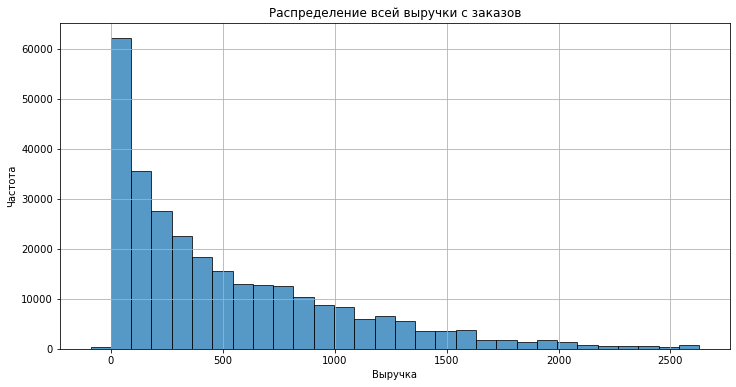

In [40]:
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
cleaned_orders_df['revenue_rub'].plot(
    kind='hist',    # Тип графика — гистограмма
    bins=30,        # Устанавливаем количество корзин
    alpha=0.75,     # Прозрачность заполнения
    edgecolor='black',  # Цвет границ столбцов
)

# Настраиваем оформление графика
plt.title('Распределение всей выручки с заказов')
plt.xlabel('Выручка')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Теперь данные более аккуратные и их можно использовать для подсчёта метрик.

Присоединим датафрейм с информацией о событиях:

In [41]:
merged_df = cleaned_orders_df.merge(events_df, on='event_id', how='inner')

### Проверка на дубликаты

**Явные дубликаты**

In [42]:
merged_df.duplicated().sum()

0

Явные дубликаты в датафрейме отсутствуют.

In [43]:
merged_df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'device_type_canonical', 'service_name',
       'tickets_count', 'days_since_prev', 'revenue_rub', 'event_name',
       'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address'],
      dtype='object')

**Неявные дубликаты**

Проверим неявные дубликаты по бронированию билета без учёта идентификаторов заказа по всем оставшимся столбцам(без order_id):

In [44]:
# поля для проверки (без учета order_id)
key_fields = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'device_type_canonical', 'service_name',
       'tickets_count', 'days_since_prev', 'revenue_rub', 'event_name',
       'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address']

# Ищем дубликаты
duplicates = merged_df.duplicated(subset=key_fields)

# Сообщаем количество дубликатов
print(f"Всего дубликатов: {duplicates.sum()}")


Всего дубликатов: 31


Таки дубликаты обнаружены. Расширим поиск и уменьшим количество столбцов.

 Проверим неявные дубликаты по бронированию билета без учёта идентификаторов заказа по выбранным столбцам. Для этого определим уникальные комбинации полей, характеризующих фактическое бронирование.

<br>**user_id:** Один и тот же пользователь мог оформить несколько заказов, следовательно, сама по себе уникальность пользователя недостаточна для идентификации дубликатов.
<br>**event_id:** Уникален для конкретного мероприятия, но отдельные пользователи могли приобрести билеты на одно и то же мероприятие многократно, поэтому одиночный критерий event_id тоже недостаточно строг.
<br>**created_ts_msk:** Это поле указывает точную дату и время оформления заказа. Возможно, разные сессии бронирования отличаются временем, но некоторые системы могут допускать бронирование одновременно несколькими пользователями в рамках одной сессии. Поэтому этот фактор полезен, но не достаточен сам по себе.
<br>**tickets_count:** Число приобретаемых билетов — важный признак возможного дублирования. Если количество билетов одинаково, это повышает вероятность дублирования.
<br>**device_type_canonical:** Устройство, с которого сделан заказ, добавляет дополнительный фильтр, так как маловероятно, что пользователь дважды подряд совершает покупку с одного устройства на одно и то же мероприятие в одно и то же время.
<br>**service_name:** Название билетного оператора. Если используется одна и та же служба для приобретения билетов, это увеличивает вероятность дублирования.

In [45]:
# поля для проверки (без учета order_id)
key_fields = ['user_id', 'event_id', 'created_ts_msk', 'tickets_count', 'device_type_canonical', 'service_name']

# Ищем дубликаты
duplicates = merged_df.duplicated(subset=key_fields)

# Сообщаем количество дубликатов
print(f"Всего дубликатов: {duplicates.sum()}")
print(f"Процент дубликатов: {round(((duplicates.sum() / len(merged_df)) * 100),2)}%")


Всего дубликатов: 40
Процент дубликатов: 0.01%


Данные некоторых заказов дублируются (40 дубликатов), что составляет 0.01% от всех данных. Посмотрим на данные дубликаты:

In [46]:
# Повторно считаем маску дубликатов
duplicates = merged_df.duplicated(subset=key_fields, keep=False)

# Получаем ID дубликатов
dup_ids = merged_df[duplicates]['order_id'].tolist()

# Выбираем и сортируем дубликаты
duplicate_records = merged_df[
    merged_df['order_id'].isin(dup_ids)
].sort_values(by=key_fields)

# Выводим первые 10 записей с нужными столбцами
duplicate_records[['user_id', 'event_id', 'created_ts_msk', 'tickets_count', 'device_type_canonical', 'service_name', 'days_since_prev']].head(10)

,user_id,event_id,created_ts_msk,tickets_count,device_type_canonical,service_name,days_since_prev
182831,06eb7897f65b433,183706,2024-08-13 16:31:07,1,mobile,Билеты в руки,0
182832,06eb7897f65b433,183706,2024-08-13 16:31:07,1,mobile,Билеты в руки,0
125610,0dc525d7bacbb0d,393430,2024-07-31 13:26:11,3,desktop,Лови билет!,11
125612,0dc525d7bacbb0d,393430,2024-07-31 13:26:11,3,desktop,Лови билет!,0
42396,206ea45ec11d478,442183,2024-10-29 16:46:54,2,mobile,Билеты в руки,32
42398,206ea45ec11d478,442183,2024-10-29 16:46:54,2,mobile,Билеты в руки,0
253243,2564e3703075008,589005,2024-10-30 10:04:15,2,mobile,Лови билет!,0
253246,2564e3703075008,589005,2024-10-30 10:04:15,2,mobile,Лови билет!,0
259195,2ecf0a4e24cae13,481392,2024-10-17 15:25:33,2,mobile,Билеты без проблем,7
259196,2ecf0a4e24cae13,481392,2024-10-17 15:25:33,2,mobile,Билеты без проблем,0


Дубликатов стало больше и мы видим, что это произошло из-за значений в столбце 'days_since_prev'. Что может объясняться тем, что происходил двойной клик и счетчик сбрасывался до 0.

Возможные причины возникновения дубликатов:
* Пользователи могут случайно совершить двойной клик при покупке билетов, вызывая создание двух заказов почти мгновенно.
* Система регистрации заказов может допустить технический баг, порождая дублирующиеся записи.
* Иногда платежные шлюзы отправляют запросы несколько раз, создавая лишние заказы.

Так как дубликаты составляют менее 1% от всех данных, их можно исключить.

In [47]:
merged_df = merged_df.drop_duplicates(subset=key_fields, keep='last', ignore_index=True)

Проверка:

In [48]:
# Ищем дубликаты
duplicates = merged_df.duplicated(subset=key_fields)

# Сообщаем количество дубликатов
print(f"Всего дубликатов: {duplicates.sum()}")

Всего дубликатов: 0


#### Создание вспомогательных столбцов

In [49]:
# средняя выручка с одного билета
merged_df['one_ticket_revenue_rub'] = merged_df['revenue_rub'] / merged_df['tickets_count']

# выделение месяца из даты
merged_df['month'] = merged_df['created_dt_msk'].dt.month

# определение сезона по месяцу
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

# применение функции для определения сезона
merged_df['season'] = merged_df['month'].apply(get_season)

In [50]:
print(f"После предобработки удалось сохранить : {round((len(merged_df) / len_df)*100,2)}% данных")

После предобработки удалось сохранить : 98.93% данных


Созданы следующие вспомогательные столбцы:
* one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие;
* month — месяц оформления заказа;
* season —столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

Выводы:
* Удалены аномальные значения, чрезмерно отличающиеся от нормального уровня дохода.
* Созданы вспомогательных столбцы:
 <br>`one_ticket_revenue_rub`: выручка с одного билета
 <br>`month`: месяц оформления заказа
 <br>`season`: сезон оформления заказа (лето, осень, зима, весна)
* незначительное количество неявных дубликатов (~0.01%) выявлено и исключено (двойные клики, ошибки серверов).
* после завершения этапа предобработки потеряно менее 1% данных, оставшиеся данные составляют около 98.93% первоначального объема.

## Исследовательский анализ данных

На стадии исследовательского анализа изучим изменение пользовательской активности в связи с сезонностью. Проанализируем динамику по таким разрезам:
* тип мероприятия `event_type_main`;
* тип устройства `device_type_canonical`;
* категория мероприятий по возрастному рейтингу `age_limit`.

### Анализ распределения заказов по сегментам и их сезонные изменения

Проанализируем количество заказов для каждого месяца:

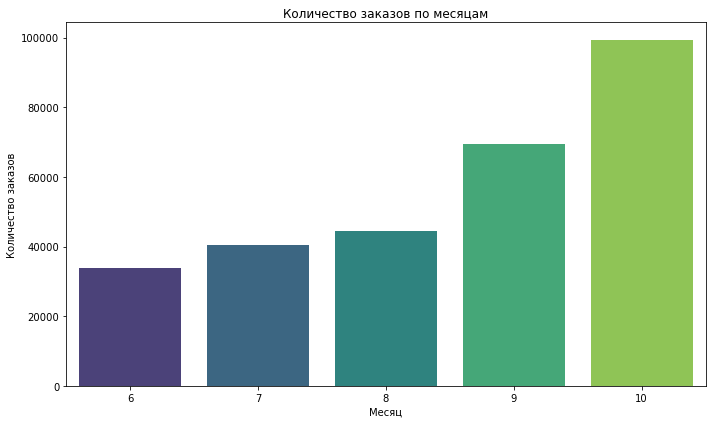

In [51]:
# Подсчет количества заказов по месяцам
monthly_orders = merged_df.groupby('month')['order_id'].count().reset_index(name='num_orders')

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='num_orders', data=monthly_orders, palette="viridis")
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

Зафиксировано увеличение заказов от июня к октябрю 2024 г.

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям:
* тип мероприятия;
* тип устройства;
* категория мероприятия по возрастному рейтингу.

<Figure size 720x432 with 0 Axes>

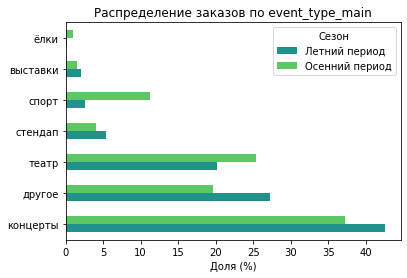

<Figure size 720x432 with 0 Axes>

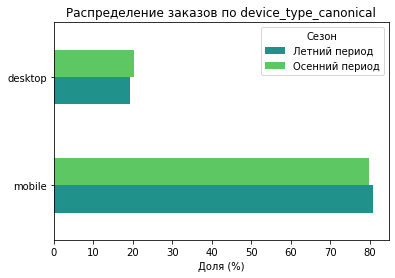

<Figure size 720x432 with 0 Axes>

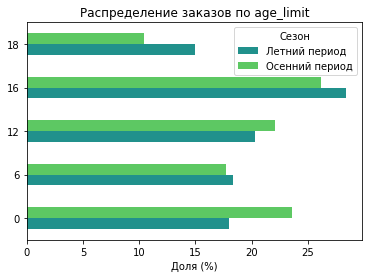

In [52]:
# Фильтрация данных
summer_data = merged_df[(merged_df['season'] == 'лето')]
autumn_data = merged_df[(merged_df['season'] == 'осень')]

# Выбор цветовой палитры
colors = ["#21918C", "#5DC863"]

# Агрегирование данных
categories = ['event_type_main', 'device_type_canonical', 'age_limit']

for category in categories:
    # Суммарное количество заказов летом и осенью
    summer_counts = summer_data[category].value_counts(normalize=True) * 100
    autumn_counts = autumn_data[category].value_counts(normalize=True) * 100
    
    # Объединение данных для удобного представления
    df_plot = pd.concat([summer_counts.rename('Летний период'), autumn_counts.rename('Осенний период')], axis=1)
    
    # График
    plt.figure(figsize=(10, 6))
    df_plot.plot(kind='barh', stacked=False, color=colors[:len(df_plot)])
    plt.title(f'Распределение заказов по {category}')
    plt.xlabel('Доля (%)')
    plt.legend(title='Сезон')
    plt.show()

Выводы:
1. Тип мероприятия (`event_type_main`)
* Концерты лидируют как в летний, так и в осенний периоды, но доля их немного снизилась осенью (с 42% до 37%). Вероятно, зрители предпочитают посещать концерты чаще в теплое время года.
* Театр, напротив, набирает популярность осенью (рост с 20% до 25%). Возможно, связано с традиционными театральными сезонами, начинающимися осенью.
* Интересно выглядит резкий всплеск интереса к спортивным мероприятиям осенью (доходят до 11%, увеличившись с 3%).
* Другие типы событий показывают незначительный спад осенью.
* Заказы на ёлки, ожидаемо начинают появляться только осенью.


2. Тип устройства (`device_type_canonical`)
* Пользователи преимущественно используют мобильные устройства для покупок билетов как летом, так и осенью (около 80%). Разрыв между мобильными устройствами и десктопами стабилен и несущественен.


3. Возрастной рейтинг (`age_limit`)
* Наиболее востребованными остаются мероприятия с возрастным ограничением 16+. Их доля стабильно высока и достигает порядка 28%. Однако осенью наблюдается некоторое снижение (до 26.20%).
* Категория 12+ незначительно увеличивается осенью (20.32% → 22.08%), демонстрируя интерес подростков и молодежи, возможно увеличение связано с началом учебного года.
* Взрослая аудитория (18+) уменьшается осенью (падение с 14.99% до 10.43%), вероятно, из-за смены приоритетов досуга в холодное время года.
* Дети младшего возраста (ограничение 6+) имеют примерно одинаковую долю, что подчеркивает стабильность семейного посещения культурных мероприятий вне зависимости от сезона.

**Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью:**

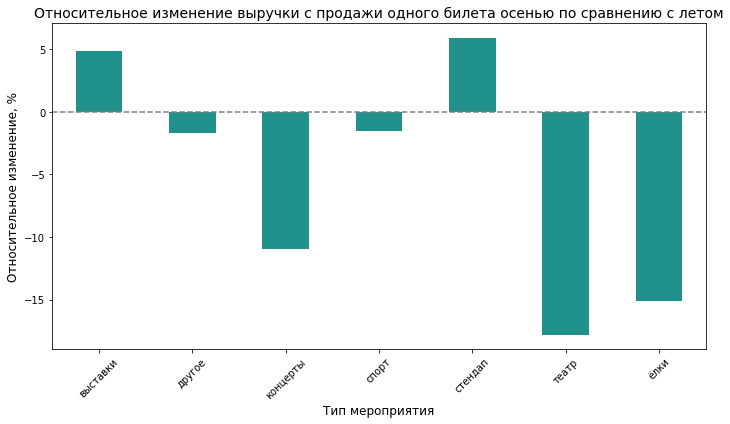

In [53]:
# Средняя выручка с одного билета по каждому типу мероприятия
avg_summer_revenues = summer_data.groupby('event_type_main')['one_ticket_revenue_rub'].mean()
avg_autumn_revenues = autumn_data.groupby('event_type_main')['one_ticket_revenue_rub'].mean()

# Соединение данных для анализа
comparison_df = pd.concat({
    'Summer': avg_summer_revenues,
    'Autumn': avg_autumn_revenues
}, axis=1)

# Рассчитаем относительное изменение (%)
comparison_df['Change %'] = ((comparison_df['Autumn'] - comparison_df['Summer']) / comparison_df['Summer']) * 100

# Выбор цветовой палитры
colors = ["#21918C"]

# Визуализация
plt.figure(figsize=(10, 6))
ax = comparison_df['Change %'].plot(kind='bar', color=colors, legend=None)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Относительное изменение выручки с продажи одного билета осенью по сравнению с летом', fontsize=14)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Относительное изменение, %', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

Выводы:

* **Выставки**
Относительное изменение: +5%.
<br>Стоимость билетов на выставки немного увеличилась осенью, что, вероятно, объясняется ростом спроса или повышением расходов организаторов.
* **Другие мероприятия**
Относительное изменение: −2%.
<br>Незначительное падение средней стоимости может свидетельствовать о небольших скидках или снижении затрат на организацию менее масштабных мероприятий.
* **Концерты**
Относительное изменение: −11%.
<br>Цена билетов на концерты существенно упала осенью, возможно, из-за сезонного падения спроса.
* **Спорт**
Относительное изменение: −1%.
<br>Практически неизменная стоимость билетов на спортивные мероприятия, небольшой спад может быть связан с маркетинговыми акциями.
* **Стендап**
Относительное изменение: +6%.
<br>Рост стоимости билетов на стендап-шоу осенью говорит о повышении интереса зрителей к развлекательным мероприятиям с ухудшением погоды.
* **Театр**
Относительное изменение: −18%.
<br>Значительное снижение стоимости билетов на театральные постановки осенью, вероятно, вызвано снижением покупательской способности аудитории или попытками увеличить посещаемость путем скидок.
* **Ёлки**
Относительное изменение: −15%.
<br>Традиционные новогодние мероприятия демонстрируют ощутимое снижение цен осенью, что вполне ожидаемо, так как основное событие ещё впереди и ожидается повышенный спрос ближе к праздникам.

**Общая картина по результатам исследования:**

* Наиболее активные посетители сервиса — любители музыки и театра, причем музыкальные мероприятия привлекают аудиторию больше летом, а театральные — осенью. Спортивные события приобретают большую популярность именно в осенний период. При этом мобильное приложение доминирует в продажах билетов круглый год. Возрастная структура аудитории показывает стабильный спрос на семейные и молодежные мероприятия, но взрослую аудиторию легче привлечь в летний период.
 
* Большинство категорий мероприятий показали либо стабильные цены, либо небольшое снижение осенью. Исключение составили выставки и стендап, где наблюдался рост стоимости билетов. Особенно значительным оказалось падение цен на театральные мероприятия, что свидетельствует о стремлении привлекать аудиторию через специальные акции и скидки.


### Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года. В вашем распоряжении данные за два осенних месяца.

**Проанализируем динамику изменений по дням для:**
* общего числа заказов;
* количества активных пользователей DAU;
* среднего числа заказов на одного пользователя;
* средней стоимости одного билета.

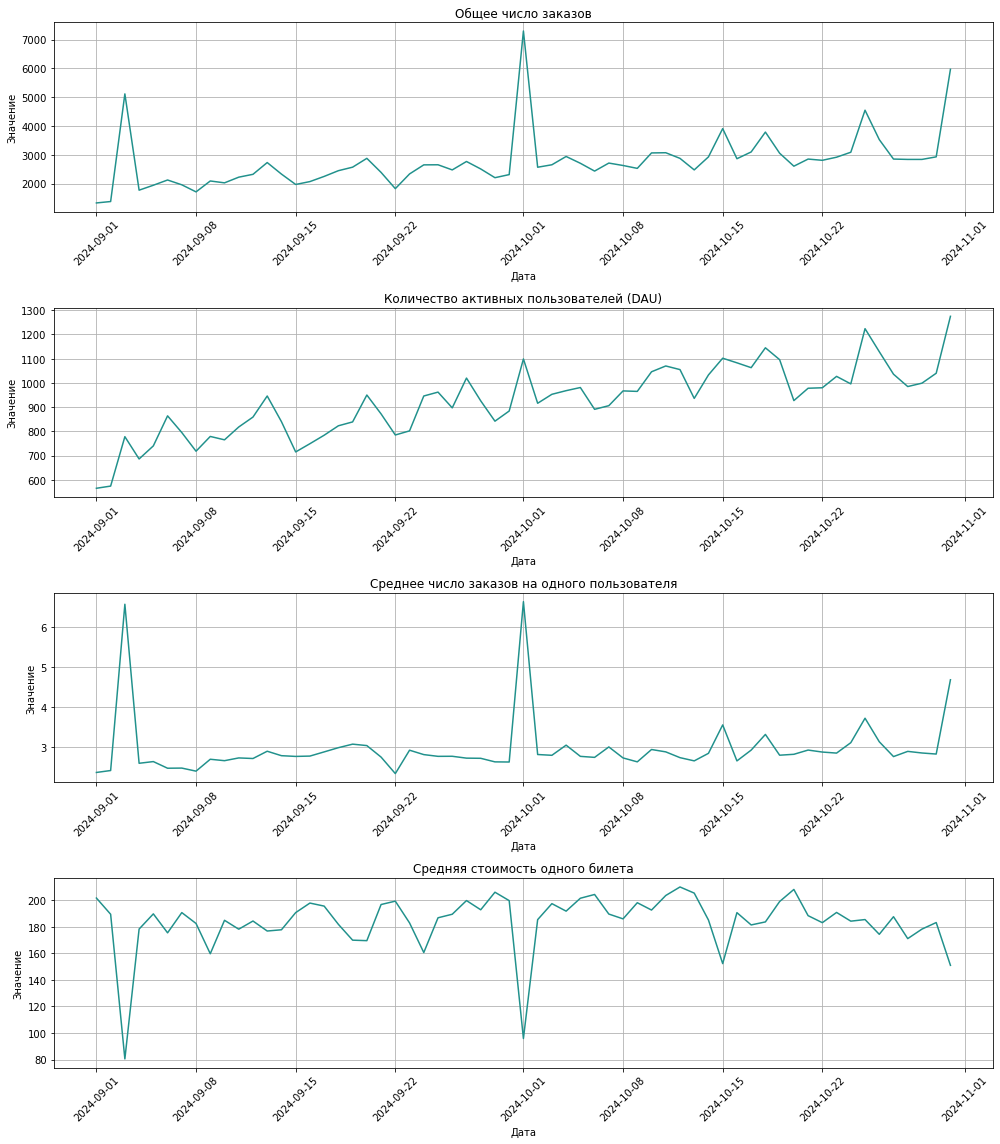

In [54]:
# Фильтрация данных за осенние месяцы
fall_data = merged_df[(merged_df['created_dt_msk'].dt.month == 9) | 
                      (merged_df['created_dt_msk'].dt.month == 10)]

# Агрегация данных по дням
daily_metrics = fall_data.groupby(fall_data['created_dt_msk']).agg({
    'order_id': 'count',                              # Общее число заказов
    'user_id': pd.Series.nunique,                     # Количество уникальных пользователей (DAU)
    'one_ticket_revenue_rub': 'mean'                  # Средняя стоимость одного билета
}).rename(columns={
    'order_id': 'total_orders',
    'user_id': 'active_users_dau',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

# Средний показатель заказов на одного пользователя
daily_metrics['orders_per_active_user'] = daily_metrics['total_orders'] / daily_metrics['active_users_dau']

# Построение графиков друг под другом
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16))

# График общего числа заказов
sns.lineplot(ax=axes[0], x=daily_metrics.index, y=daily_metrics['total_orders'], color=colors[0])
axes[0].set_title('Общее число заказов')
axes[0].grid(True)

# График количества активных пользователей (DAU)
sns.lineplot(ax=axes[1], x=daily_metrics.index, y=daily_metrics['active_users_dau'], color=colors[0])
axes[1].set_title('Количество активных пользователей (DAU)')
axes[1].grid(True)

# График среднего числа заказов на одного пользователя
sns.lineplot(ax=axes[2], x=daily_metrics.index, y=daily_metrics['orders_per_active_user'], color=colors[0])
axes[2].set_title('Среднее число заказов на одного пользователя')
axes[2].grid(True)

# График средней стоимости одного билета
sns.lineplot(ax=axes[3], x=daily_metrics.index, y=daily_metrics['avg_ticket_price'], color=colors[0])
axes[3].set_title('Средняя стоимость одного билета')
axes[3].grid(True)

# Общие настройки
for ax in axes:
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Анализируя представленные данные, можно выделить несколько важных аспектов активности пользователей осенью 2024 года:

* `Общее число заказов (total_orders)`:
<br>Начиная с сентября наблюдается постепенный рост количества заказов вплоть до середины октября. Пик активности пришёлся на конец октября (особенно заметен скачок 1 октября и 31 октября).
Самые высокие показатели наблюдаются в конце месяца октября, что, вероятно, связано с праздничными событиями или распродажами.
Так же заметен резкий рост числа заказов 10-ого октября, возможно связанный с проведением каких-либо акций.
* `Количество активных пользователей (active_users_dau)`:
<br>Стабильно растёт число активных пользователей в сентябре и октябре, достигая пика в середине октября (примерно 1000—1200 пользователей в день).
<br>Наибольшее количество активных пользователей пришлось на последнюю неделю октября, что говорит о высоком вовлечении пользователей в праздничные мероприятия или специальные акции.
* `Среднее число заказов на одного пользователя (orders_per_active_user)`:
<br>Данный показатель колеблется от ~2 до ~4 заказов на пользователя в день. Наибольшее значение приходится на начало октября (10 октября — более 6 заказов на пользователя), что свидетельствует о повышенной активности покупателей в этот период.
<br>Обычно пользователи покупают от 2 до 3 билетов, но иногда активность резко возрастает.
* `Средняя стоимость одного билета (avg_ticket_price)`:
<br>Стоимость билетов варьируется от ~150 до ~210 рублей. Несмотря на небольшие колебания, можно заметить, что средняя стоимость постепенно снижается к концу октября, достигая минимума в конце месяца (150-180 рублей).
<br>Периодическое падение стоимости билетов совпадает с ростом числа заказов (ярче всех выражено падение 10-ого октября), что говорит о возможном проведении специализированных акций и скидок на билеты.

**Заключение:**
<br>Осенний период показал активный рост как в плане общего числа заказов, так и в вовлечённости пользователей. Максимальный спрос пришелся на конец октября, что могло быть вызвано проведением массовых мероприятий, распродажами или специальными акциями. Средняя стоимость билетов оставалась стабильной, с небольшим снижением ближе к концу месяца, что может указывать на попытки повысить привлекательность услуг через скидки и выгодные предложения. Также ярко выражено проведение специализированных акций 10-ого октября.

**Недельная цикличность**

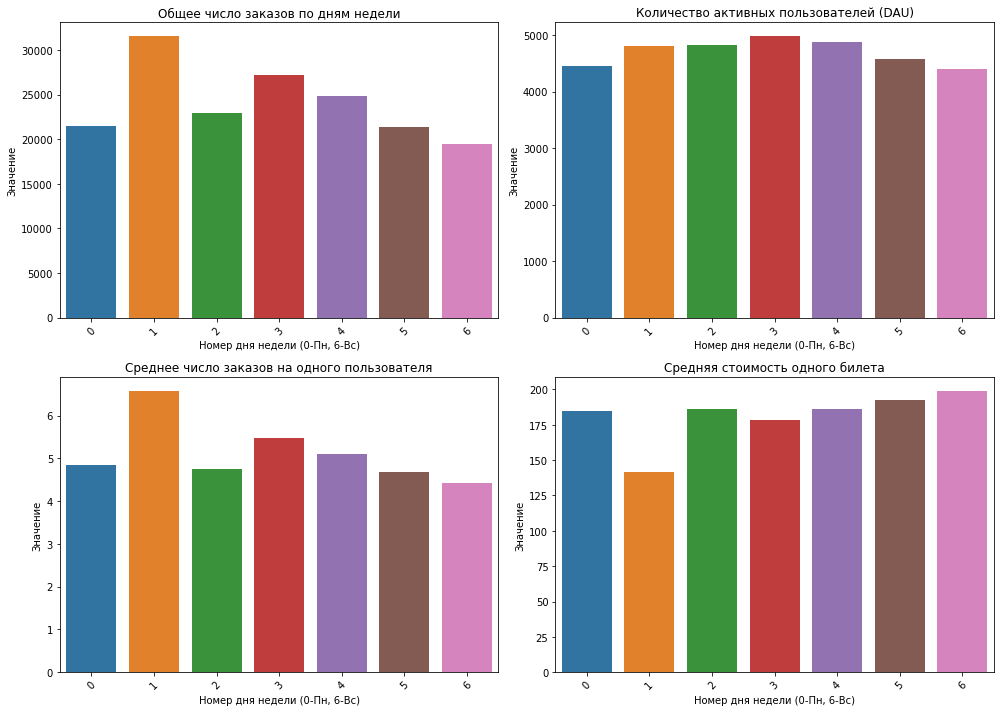

In [55]:
# копия
fall_data = fall_data.copy()

# Безопасное добавление столбца с номером дня недели
fall_data.loc[:, 'weekday'] = fall_data['created_dt_msk'].dt.weekday

# Агрегация данных по дням недели
weekly_metrics = fall_data.groupby('weekday').agg({
    'order_id': 'count',                              # Общее число заказов
    'user_id': pd.Series.nunique,                     # Количество уникальных пользователей (DAU)
    'one_ticket_revenue_rub': 'mean'                  # Средняя стоимость одного билета
}).rename(columns={
    'order_id': 'total_orders',
    'user_id': 'active_users_dau',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

# Средний показатель заказов на одного пользователя
weekly_metrics['orders_per_active_user'] = weekly_metrics['total_orders'] / weekly_metrics['active_users_dau']

# Сортируем дни недели в правильном порядке (от 0 до 6)
weekly_metrics.sort_index(inplace=True)

# Построение графиков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# График общего числа заказов
sns.barplot(x=weekly_metrics.index, y=weekly_metrics['total_orders'], ax=axes[0][0])
axes[0][0].set_title('Общее число заказов по дням недели')

# График количества активных пользователей (DAU)
sns.barplot(x=weekly_metrics.index, y=weekly_metrics['active_users_dau'], ax=axes[0][1])  # Исправление здесь!
axes[0][1].set_title('Количество активных пользователей (DAU)')

# График среднего числа заказов на одного пользователя
sns.barplot(x=weekly_metrics.index, y=weekly_metrics['orders_per_active_user'], ax=axes[1][0])
axes[1][0].set_title('Среднее число заказов на одного пользователя')

# График средней стоимости одного билета
sns.barplot(x=weekly_metrics.index, y=weekly_metrics['avg_ticket_price'], ax=axes[1][1])
axes[1][1].set_title('Средняя стоимость одного билета')

# Общие настройки
for ax in axes.flat:
    ax.set_xlabel('Номер дня недели (0-Пн, 6-Вс)')
    ax.set_ylabel('Значение')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

* Общее число заказов (total_orders):
В будние дни (с понедельника по пятницу) среднее количество заказов варьировалось от 21533 до 31532, при этом наибольшее число заказов было зарегистрировано во вторник (31532).
Выходные дни характеризуются меньшими значениями: суббота — 21361, воскресенье — 19424.

* Количество активных пользователей (active_users_dau):
В рабочие дни количество уникальных пользователей составляло от 4450 до 4974, максимум пришелся на четверг (4974).
В выходные активность падает: суббота — 4574, воскресенье — 4399.

* Среднее число заказов на одного пользователя (orders_per_active_user):
Рабочие дни показывают высокий показатель: от 4.75 до 6.57 заказов на пользователя.
В выходные количество заказов на одного пользователя ниже: суббота — 4.67, воскресенье — 4.42.
Это подтверждает предположение, что пользователи делают больше заказов в будние дни.

* Средняя стоимость одного билета (avg_ticket_price):
Будние дни демонстрируют среднюю стоимость билета от 141 до 198 рублей.
Выходные дни показывают немного более высокую стоимость билетов: суббота — 192 рубля, воскресенье — 198 рублей.
Таким образом, билеты в выходные дороже, что может означать более высокий спрос на премиальные мероприятия или специальные предложения.

**Заключение:**
<br>Осенний период показал активный рост как в плане общего числа заказов, так и в вовлечённости пользователей. Максимальный спрос пришелся на конец октября, что могло быть вызвано проведением массовых мероприятий, распродажами или специальными акциями. Средняя стоимость билетов оставалась стабильной, с небольшим снижением ближе к концу месяца, что может указывать на попытки повысить привлекательность услуг через скидки и выгодные предложения. Также ярко выражено проведение специализированных акций 10-ого октября.

Основное отличие между буднями и выходными:
* в будние дни пользователи активнее, делают больше заказов и тратят больше денег на приобретение билетов;
* в выходные дни активность пользователей снижается, количество заказов становится меньше, а средняя стоимость билетов повышается.

### Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам:

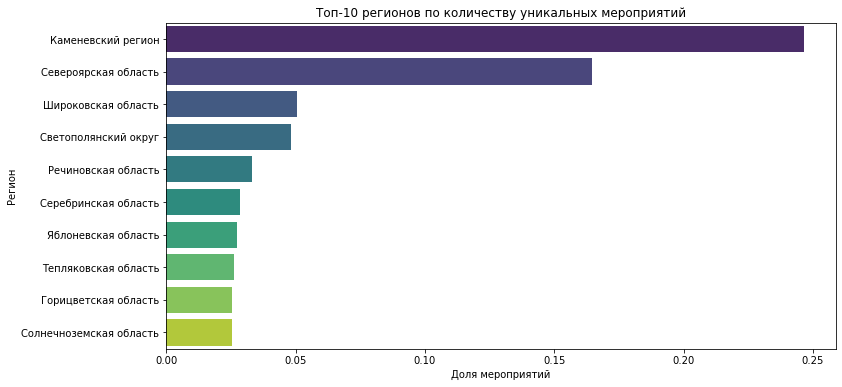

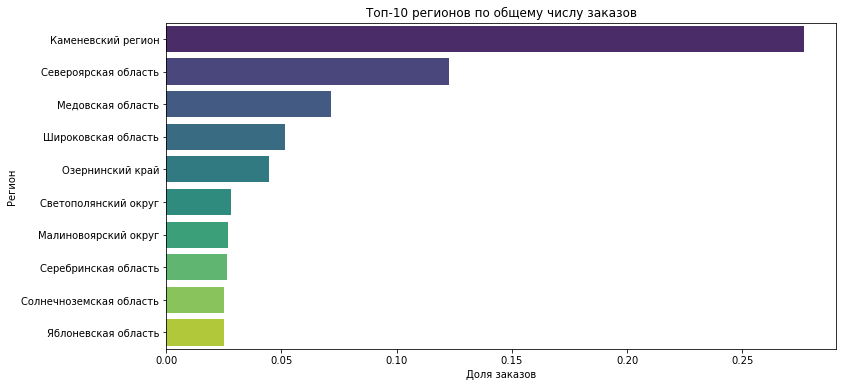

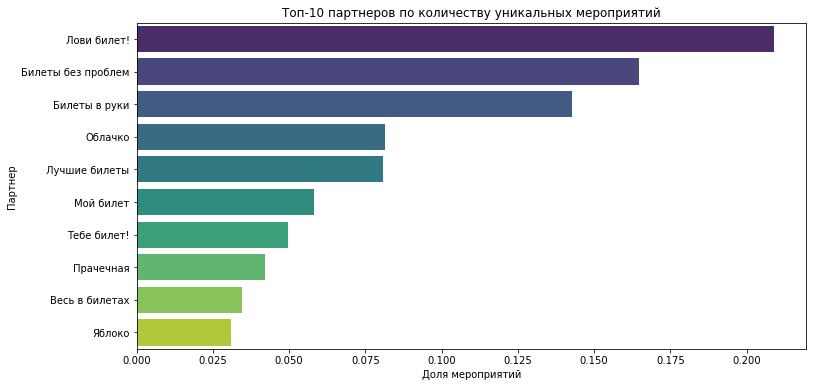

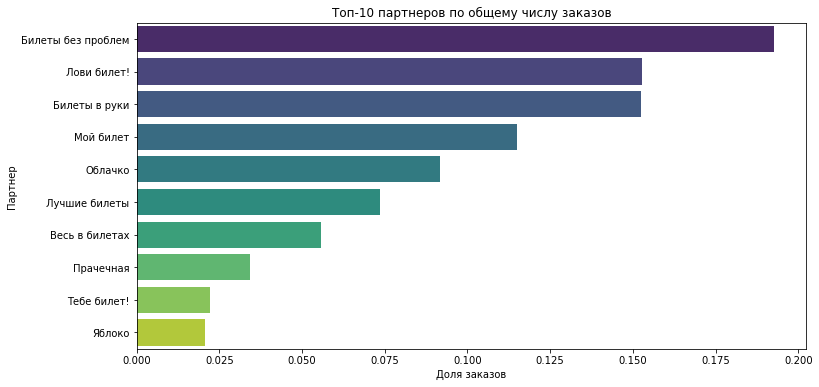

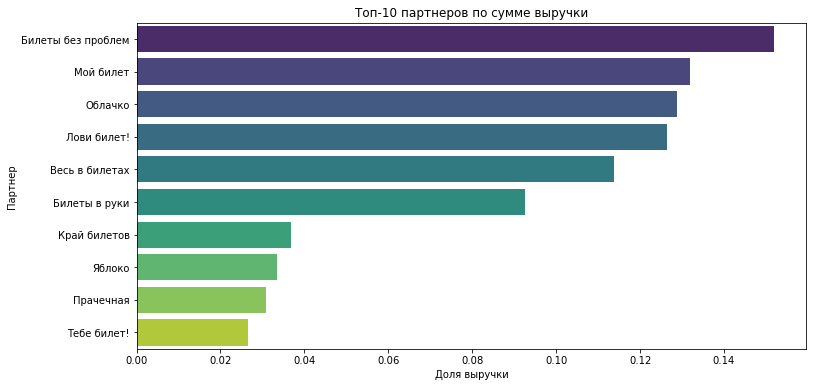

In [56]:
# считаем количество уникальных мероприятий и заказов по регионам
region_analysis = fall_data.groupby('region_name').agg({
    'event_id': pd.Series.nunique,        # Уникальные мероприятия
    'order_id': 'count'                   # Всего заказов
}).rename(columns={'event_id': 'unique_events', 'order_id': 'total_orders'})

# Считаем долю мероприятий и заказов в каждом регионе
region_analysis['event_share'] = region_analysis['unique_events'] / region_analysis['unique_events'].sum()
region_analysis['order_share'] = region_analysis['total_orders'] / region_analysis['total_orders'].sum()

# Топ-10 регионов по уникальным мероприятиям
top_regions_by_events = region_analysis.sort_values(by='unique_events', ascending=False).head(10)

# Топ-10 регионов по общему числу заказов
top_regions_by_orders = region_analysis.sort_values(by='total_orders', ascending=False).head(10)

# Считаем количество уникальных мероприятий, заказов и выручку по партнерам
partner_analysis = fall_data.groupby('service_name').agg({
    'event_id': pd.Series.nunique,        # Уникальные мероприятия
    'order_id': 'count',                  # Всего заказов
    'revenue_rub': 'sum'                  # Сумма выручки
}).rename(columns={'event_id': 'unique_events', 'order_id': 'total_orders', 'revenue_rub': 'revenue'})

# Считаем долю мероприятий, заказов и выручки по каждому партнеру
partner_analysis['event_share'] = partner_analysis['unique_events'] / partner_analysis['unique_events'].sum()
partner_analysis['order_share'] = partner_analysis['total_orders'] / partner_analysis['total_orders'].sum()
partner_analysis['revenue_share'] = partner_analysis['revenue'] / partner_analysis['revenue'].sum()

# Топ-10 партнеров по уникальным мероприятиям
top_partners_by_events = partner_analysis.sort_values(by='unique_events', ascending=False).head(10)

# Топ-10 партнеров по общим заказам
top_partners_by_orders = partner_analysis.sort_values(by='total_orders', ascending=False).head(10)

# Топ-10 партнеров по выручке
top_partners_by_revenue = partner_analysis.sort_values(by='revenue', ascending=False).head(10)

# отображаем топ-10 регионов по мероприятиям
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_by_events['event_share'], y=top_regions_by_events.index, palette="viridis")
plt.title('Топ-10 регионов по количеству уникальных мероприятий')
plt.xlabel('Доля мероприятий')
plt.ylabel('Регион')
plt.show()

# отображаем топ-10 регионов по заказам
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_by_orders['order_share'], y=top_regions_by_orders.index, palette="viridis")
plt.title('Топ-10 регионов по общему числу заказов')
plt.xlabel('Доля заказов')
plt.ylabel('Регион')
plt.show()

# отображаем топ-10 партнеров по мероприятиям
plt.figure(figsize=(12, 6))
sns.barplot(x=top_partners_by_events['event_share'], y=top_partners_by_events.index, palette="viridis")
plt.title('Топ-10 партнеров по количеству уникальных мероприятий')
plt.xlabel('Доля мероприятий')
plt.ylabel('Партнер')
plt.show()

# отображаем топ-10 партнеров по заказам
plt.figure(figsize=(12, 6))
sns.barplot(x=top_partners_by_orders['order_share'], y=top_partners_by_orders.index, palette="viridis")
plt.title('Топ-10 партнеров по общему числу заказов')
plt.xlabel('Доля заказов')
plt.ylabel('Партнер')
plt.show()

# отображаем топ-10 партнеров по выручке
plt.figure(figsize=(12, 6))
sns.barplot(x=top_partners_by_revenue['revenue_share'], y=top_partners_by_revenue.index, palette="viridis")
plt.title('Топ-10 партнеров по сумме выручки')
plt.xlabel('Доля выручки')
plt.ylabel('Партнер')
plt.show()

Вывод:

**Регионы:** лидером по количеству уникальных мероприятий и общему числу заказов стал Каменевский регион, охватывающий почти четверть всех мероприятий и заказов. Североярская область занимает второе место, однако значительно уступает первому региону. Остальные регионы представлены значительно меньшими значениями.

**Партнеры:** среди партнеров выделяются несколько лидеров по различным показателям:
* По количеству уникальных мероприятий лидером является сервис «Лови билет!» с долей около 21%. Далее следуют сервисы «Билеты без проблем» и «Билеты в руки».
* По общему числу заказов уверенно лидирует «Билеты без проблем» с долей 19%, опережая ближайших конкурентов («Лови билет!» и «Билеты в руки»).
* По объему выручки первое место удерживает сервис «Билеты без проблем», второй идет «Мой билет», замыкают тройку лидеров «Облачко» и «Лови билет!».

Таким образом, хотя в рейтинге партнеров видны явные лидеры по разным критериям, четкий единый лидер по всем направлениям отсутствуемт. Каждый крупный игрок обладает своими преимуществами, и их стратегии продвижения различаются в зависимости от целей.

## Статистический анализ данных

Необходимо проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств:
* среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
* среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Перед подготовкой датафреймов, проверим, есть ли пользователи, которые имели активность и на мобильных, и на стационарных устройствах.

Если такие пользователи будут выявлены, их необходимо удалить, что бы выборки были независимы.

In [57]:
# Получаем индексы пользователей, использовавших оба типа устройств
cross_device_users = (
    fall_data
    .groupby('user_id')
    .agg({'device_type_canonical': 'nunique'})
    .query('device_type_canonical > 1')
    .index
)

# Количество пересекающихся пользователей
num_cross_device_users = len(cross_device_users)

# Исходное количество пользователей
initial_num_users = fall_data['user_id'].nunique()

# Исключаем этих пользователей из общего датасета
filtered_data = fall_data[~fall_data['user_id'].isin(cross_device_users)]

# Количество пользователей после очистки
remaining_num_users = filtered_data['user_id'].nunique()

# Выводим результаты
print(f"Количество пользователей до очистки: {initial_num_users}")
print(f"Количество пересекающихся пользователей: {num_cross_device_users}")
print(f"Количество пользователей после очистки: {remaining_num_users}")
print(f"Доля пользователей после очистки: {remaining_num_users / initial_num_users}")

Количество пользователей до очистки: 15821
Количество пересекающихся пользователей: 3250
Количество пользователей после очистки: 12571
Доля пользователей после очистки: 0.7945768282662284


Удалены 3250 пользователей, которые имели активность и на мобильных, и на стационарных устройствах. После очистки сохранены 79% данных.

### Проверка первой гипотезы. Среднее количество заказов на одного пользователя

**H₀ (нулевая гипотеза)**: Среднее количество заказов на одного пользователя мобильного приложения равно среднему количеству заказов на одного пользователя стационарных устройств.

**H₁ (альтернативная гипотеза)**: Среднее количество заказов на одного пользователя мобильного приложения выше, чем у пользователей стационарных устройств.

Изучим числовые характеристики действий пользователя, которые будут использоваться для расчёта метрики, и проверим в них аномалии и выбросы. В нашем случае - среднее количество заказов на одного пользователя.

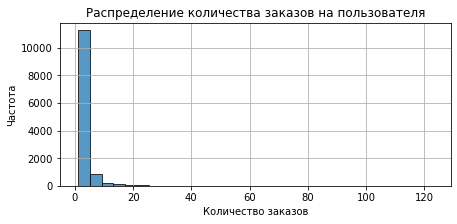

In [58]:
# Подсчитываем количество заказов на пользователя
orders_per_user = (
    filtered_data
    .groupby('user_id')
    ['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'})
)

# Строим гистограмму
plt.figure(figsize=(7, 3))

# Гистограмма количества заказов на пользователя
orders_per_user['number_of_orders'].plot(
    kind='hist',  # Тип графика — гистограмма
    bins=30,      # Количество корзин
    alpha=0.75,   # Прозрачность заливки
    edgecolor='black'  # Цвет границы прямоугольников
)

# Настройка заголовков и осей
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

В данных обнаружены небольшие выбросы, для корректного проведения тестирования, уберем их.

In [59]:
# Нахождение 99-го квантиля
quantile_99 = orders_per_user['number_of_orders'].quantile(0.99)

# Удаление пользователей с аномальным числом заказов
cleaned_filtered_data = filtered_data.merge(
    orders_per_user.query("number_of_orders <= @quantile_99"),
    on="user_id",
    how="inner"
).drop(columns=['number_of_orders'])

Проверим распределение:

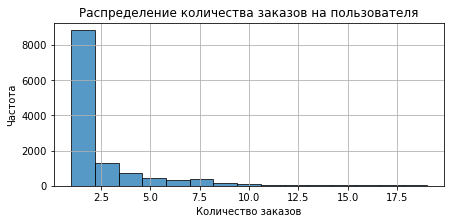

In [60]:
# Подсчитываем количество заказов на пользователя
orders_per_user = (
    cleaned_filtered_data
    .groupby('user_id')
    ['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'})
)

# Строим гистограмму
plt.figure(figsize=(7, 3))

# Гистограмма количества заказов на пользователя
orders_per_user['number_of_orders'].plot(
    kind='hist',  # Тип графика — гистограмма
    bins=15,      # Количество корзин
    alpha=0.75,   # Прозрачность заливки
    edgecolor='black'  # Цвет границы прямоугольников
)

# Настройка заголовков и осей
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

Теперь данные более аккуратные, и их можно использовать для подсчёта метрик.

Подготовим датафреймы:

In [61]:
# Подготовка датафреймов
mobile_fall = cleaned_filtered_data[cleaned_filtered_data['device_type_canonical'] == 'mobile']
desktop_fall = cleaned_filtered_data[cleaned_filtered_data['device_type_canonical'] == 'desktop']

Рассчитаем количество пользователей в каждой группе:

In [62]:
# Количество уникальных пользователей в мобильной группе
unique_mobile_users = mobile_fall['user_id'].nunique()

# Количество уникальных пользователей в стационарной группе
unique_desktop_users = desktop_fall['user_id'].nunique()

print(f"Уникальных пользователей мобильных устройств: {unique_mobile_users}")
print(f"Уникальных пользователей стационарных устройств: {unique_desktop_users}")

Уникальных пользователей мобильных устройств: 10837
Уникальных пользователей стационарных устройств: 1614


In [63]:
# Рассчитываем долю уникальных пользователей мобильных и стационарных устройств
mobile_users_percentage = 100 * unique_mobile_users / cleaned_filtered_data['user_id'].nunique()
desktop_users_percentage = 100 * unique_desktop_users / cleaned_filtered_data['user_id'].nunique()

# Выводим полученные проценты
print(f"Мобильных пользователей: {mobile_users_percentage:.2f}%")
print(f"Стационарных пользователей: {desktop_users_percentage:.2f}%")

Мобильных пользователей: 87.04%
Стационарных пользователей: 12.96%


Группа пользователей мобильных устройств составила 87%, группа пользователей стационарных компьютеров составила 13%. Важно обратить на это внимание.

Посмотрим основные статистики по группам:

In [64]:
# Агрегация количества заказов на пользователя по каждому типу устройства
mobile_orders_per_user = (
    mobile_fall
    .groupby('user_id')
    ['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'})
)

desktop_orders_per_user = (
    desktop_fall
    .groupby('user_id')
    ['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'})
)

# Основные статистики по количеству заказов на пользователя
mobile_stats = mobile_orders_per_user['number_of_orders'].describe()
desktop_stats = desktop_orders_per_user['number_of_orders'].describe()

# Выводим статистику
print("Статистика по мобильным пользователям:")
print(mobile_stats)

print("\nСтатистика по стационарным пользователям:")
print(desktop_stats)

Статистика по мобильным пользователям:
count    10837.000000
mean         2.577835
std          2.645116
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: number_of_orders, dtype: float64

Статистика по стационарным пользователям:
count    1614.000000
mean        1.791202
std         1.704564
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        19.000000
Name: number_of_orders, dtype: float64


**Разница между группами:**

* Пользователи мобильных устройств демонстрируют намного более активное поведение: они совершают в среднем больше заказов (2.58 против 1.79), и разница хорошо видна и по медиане (2 против 1).
* Стандартное отклонение выше у мобильных пользователей, что подтверждает больший разброс в поведении — одни пользователи могут совершать много заказов, другие — совсем мало.
* Стационарные пользователи ведут себя более консервативно: большинство из них ограничивается одним-двумя заказами.

Данные показатели поддерживает гипотезу, что мобильное устройство удобнее и быстрее для пользователей, позволяющее быстро приобретать билеты в любое удобное время и месте. 

Проверим насколько данное различие статистически значимо.

Поскольку данная метрика метрика касается изменения среднего значения и «на пользователя», которая не будет долей или отношением, можно утверждать, что она непрерывна. Так как распределение количества заказов на пользователя достаточно асимметричное и количество пользователей в каждой группе сильео различно, для проверки гипотезы применим тест Манна-Уитни.

In [65]:
# Тест Манна-Уитни для сравнения средних чисел заказов на пользователя
statistic, p_value = mannwhitneyu(mobile_orders_per_user['number_of_orders'], desktop_orders_per_user['number_of_orders'], alternative='greater')

# Результаты
print(f"Тестовая статистика U: {statistic:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Гипотеза H₀ отвергнута: среднее количество заказов на пользователя мобильных устройств выше, чем у стационарных.")
else:
    print("Нет оснований отвергнуть гипотезу: различия в среднем количестве заказов между группами не найдены.")

Тестовая статистика U: 10370852.0000
P-значение: 0.0000
Гипотеза H₀ отвергнута: среднее количество заказов на пользователя мобильных устройств выше, чем у стационарных.


Проведённый статистический анализ продемонстрировал следующее:

**Описание данных:**
* Среди мобильных пользователей среднее количество заказов составило 2.58, в то время как среди пользователей стационарных устройств — 1.79.
* Разница в средних значениях подкрепляется и медианой: у мобильных пользователей она равна 2, а у стационарных — 1.
* Стандартное отклонение выше у мобильных пользователей, что подтверждает наличие большего разнообразия в поведении пользователей смартфонов.

Статистический тест (Манна-Уитни):
Тестовая статистика U: 10370852
P-значение: 0.0000

Поскольку p-значение близко к нулю (менее заданного уровня значимости α=0.05), нулевая гипотеза была отвергнута. Соответственно среднее количество заказов на одного пользователя мобильных устройств значительно выше, чем у пользователей стационарных устройств.

**Заключение:**
Результаты однозначно указывают на превосходящую активность пользователей мобильных устройств. Они совершают значительно больше заказов билетов, что может служить важным фактором для развития продуктов и стратегий бизнеса. Например, улучшение функционала мобильного приложения или развитие специальных предложений именно для мобильных пользователей может стать ключевым направлением дальнейшего роста.

### Проверка второй гипотезы

**H₀ (нулевая гипотеза)**: Среднее время между заказами пользователей мобильных устройств равняется среднему времени между заказами пользователей стационарных устройств.

**H₁ (альтернативная гипотеза)**: Среднее время между заказами пользователей мобильных устройств выше, чем у пользователей стационарных устройств.

In [66]:
# Создаем временную последовательность для расчета разницы между заказами
filtered_data_sorted = filtered_data.sort_values(by=['user_id', 'created_ts_msk'])

# Создаем временной сдвиг внутри группы пользователей
filtered_data_sorted['prev_order_time'] = filtered_data_sorted.groupby('user_id')['created_ts_msk'].shift(1)

# Рассчитываем разницу во времени между заказами
filtered_data_sorted['time_between_orders'] = (filtered_data_sorted['created_ts_msk'] - filtered_data_sorted['prev_order_time']).dt.total_seconds() / (60*60*24)  # Переводим в дни

# Оставляем только строки с ненулевым интервалом
filtered_data_with_interval = filtered_data_sorted.dropna(subset=['time_between_orders'])

Посмотрим на распределение ключевой метрики:

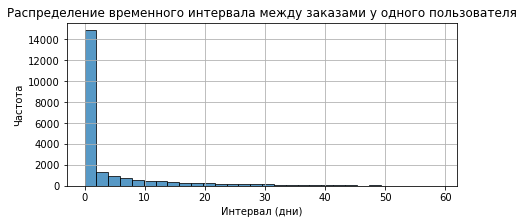

In [67]:
# Строим гистограмму
plt.figure(figsize=(7, 3))

# Гистограмма количества заказов на пользователя
filtered_data_with_interval['time_between_orders'].plot(
    kind='hist',  # Тип графика — гистограмма
    bins=30,      # Количество корзин
    alpha=0.75,   # Прозрачность заливки
    edgecolor='black'  # Цвет границы прямоугольников
)

# Настройка заголовков и осей
plt.title('Распределение временного интервала между заказами у одного пользователя')
plt.xlabel('Интервал (дни)')
plt.ylabel('Частота')

# Добавляем сетку
plt.grid()

# Выводим график
plt.show()

Аномально большие выбросы не обнаружены.

Рассчитаем количество пользователей в каждой группе:

In [68]:
# Группа мобильных пользователей
mobile_users = filtered_data_with_interval[filtered_data_with_interval['device_type_canonical'] == 'mobile']

# Группа стационарных пользователей
desktop_users = filtered_data_with_interval[filtered_data_with_interval['device_type_canonical'] == 'desktop']

# Количество уникальных пользователей в каждой группе
num_mobile_users = mobile_users['user_id'].nunique()
num_desktop_users = desktop_users['user_id'].nunique()

print(f"Пользователей мобильных устройств: {num_mobile_users}")
print(f"Пользователей стационарных устройств: {num_desktop_users}")

Пользователей мобильных устройств: 5576
Пользователей стационарных устройств: 578


In [69]:
# Рассчитываем долю уникальных пользователей мобильных и стационарных устройств
mobile_users_percentage = 100 * num_mobile_users / filtered_data_with_interval['user_id'].nunique()
desktop_users_percentage = 100 * num_desktop_users / filtered_data_with_interval['user_id'].nunique()

# Выводим полученные проценты
print(f"Мобильных пользователей: {mobile_users_percentage:.2f}%")
print(f"Стационарных пользователей: {desktop_users_percentage:.2f}%")

Мобильных пользователей: 90.61%
Стационарных пользователей: 9.39%


Группа пользователей мобильных устройств составила 91%, группа пользователей стационарных компьютеров составила 9%. Важно обратить внимание на такое большое расхождение в размерах групп.

Посмотрим основные статистики по группам:

In [70]:
# интервалы отдельно для мобильных и стационарных пользователей
mobile_time_between_orders = mobile_users['time_between_orders']
desktop_time_between_orders = desktop_users['time_between_orders']

# Основные статистики
mobile_stats = mobile_time_between_orders.describe()
desktop_stats = desktop_time_between_orders.describe()

print("Статистика по мобильным пользователям:")
print(mobile_stats)

print("\nСтатистика по стационарным пользователям:")
print(desktop_stats)

Статистика по мобильным пользователям:
count    20360.000000
mean         4.620108
std          8.981863
min          0.000000
25%          0.001586
50%          0.017425
75%          4.942135
max         59.068079
Name: time_between_orders, dtype: float64

Статистика по стационарным пользователям:
count    1570.000000
mean        2.568115
std         7.581248
min         0.000012
25%         0.000755
50%         0.002442
75%         0.025480
max        56.679896
Name: time_between_orders, dtype: float64


**Среднее время между заказами:**
Среднее время между заказами у мобильных пользователей (4.62 дня) заметно выше, чем у стационарных (2.57 дня). Это предполагает, что пользователи мобильных устройств склонны дольше ждать перед повторным заказом.

**Медианное время:**
Медианное время между заказами минимально в обеих группах, указывая на частое немедленное повторение заказов. Однако медиана у мобильных пользователей выше (0.0174 дня), чем у стационарных (0.0024 дня), что дополнительно подчёркивает задержку между заказами у мобильных пользователей.

**Разброс данных:**
Оба распределения обладают высоким стандартным отклонением, что говорит о сильном разбросе интервалов между заказами.

Проверим насколько данное различие статистически значимо.

Поскольку метрика метрика касается изменения среднего значения и «на пользователя», которая не будет долей или отношением, можно утверждать, что она непрерывна. Так как распределение времени между заказами на пользователя достаточно асимметричное и количество пользователей в каждой группе сильео различно, для проверки гипотезы применим тест Манна-Уитни.

In [71]:
# Тест Манна-Уитни с правильным выбором альтернативы
statistic, p_value = mannwhitneyu(mobile_time_between_orders, desktop_time_between_orders, alternative='greater')

# Результаты
print(f"Тестовая статистика U: {statistic:.4f}")
print(f"P-значение: {p_value:.4f}")

alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Гипотеза H₀ отвергнута: среднее время между заказами мобильных пользователей больше, чем у стационарных.")
else:
    print("Нет оснований отвергнуть гипотезу: различия в среднем времени между заказами между группами не найдены.")


Тестовая статистика U: 20526178.0000
P-значение: 0.0000
Гипотеза H₀ отвергнута: среднее время между заказами мобильных пользователей больше, чем у стационарных.


Проведённый статистический анализ продемонстрировал следующее:

**Описание данных:**

* Среди мобильных пользователей среднее время между заказами составило 4.62 дня, в то время как среди пользователей стационарных устройств — 2.57 дня.
* Разница в средних значениях подтверждается и медианой: у мобильных пользователей она равна 0.0174 дня, а у стационарных — 0.0024 дня.
* Стандартное отклонение выше у мобильных пользователей, что подтверждает наличие большего разнообразия в поведении пользователей смартфонов.

**Статистический тест (Манна-Уитни):**

Тестовая статистика U: 20526178
P-значение: 0.0000

Поскольку p-значение близко к нулю (менее заданного уровня значимости α=0.05), нулевая гипотеза была отвергнута. Соответственно, среднее время между заказами у мобильных пользователей значительно больше, чем у пользователей стационарных устройств.

**Заключение:**

Результаты теста подтверждают гипотезу, что пользователи мобильных устройств, в среднем, ждут дольше перед повторным заказом. Это может служить основой для разработки стратегических решений, направленных на повышение лояльности мобильных пользователей путём предоставления специальных предложений или улучшения удобства пользования мобильным приложением.

## Общий вывод и рекомендации

**Характеристика данных:** Исследование проведено на основе трёх датасетов сервиса «Яндекс.Афиша»: информация о заказах билетов (final_tickets_orders_df), сведения о мероприятиях (final_tickets_events_df) и курсы валют (final_tickets_tenge_df). Объём данных составил 290 тыс. заказов за период с июня по октябрь 2024 года.

**Ключевые наблюдения:**

* Популярность мероприятий: Концерты лидируют в летний период, театры становятся популярнее осенью. Ёлочные мероприятия появляются исключительно осенью.
* Изменение выручки: Стоимость билетов на многие мероприятия уменьшалась осенью, особенно на спектакли и елки. Исключение — выставки и стендап, где цена возросла.
* Активность пользователей: Пользователи мобильных устройств совершили больше заказов (2.58 заказа на человека) и ждали дольше между заказами (4.62 дня), чем пользователи стационарных устройств (соответственно 1.79 заказа и 2.57 дня).
* Сезонность: Осенью отмечается высокая активность пользователей, пик которой приходился на октябрь. Недельные графики выявили, что самая активная аудитория выходит в будние дни, а наименьшая активность фиксируется в выходные.
* Лидеры по регионам и партнерам:  лидером по количеству уникальных мероприятий и общему числу заказов стал Каменевский регион, охватывающий почти четверть всех мероприятий и заказов. Среди партнёров лидирующие позиции занимают операторы «Билеты без проблем» и «Лови билет!».

**Рекомендации**

* Повышение привлекательности мобильного приложения. Пользователям мобильных устройств следует предложить удобные инструменты быстрой покупки билетов и персонализированные предложения, учитывая предпочтения этой активной аудитории.
* Акцент на осеннюю активность. Повышенный спрос осенью требует организации мероприятий и рекламных кампаний, ориентированных на привлечение внимания пользователей, особенно молодёжи и любителей театров.
* Оптимизация ценовой политики. Следует учитывать сезонные тренды и предлагать гибкую систему скидок и бонусов, особенно для театралов и семейных мероприятий.
* Расширение сотрудничества с партнерами. Партнёрство с ведущими операторами поможет расширить ассортимент мероприятий и увеличить доходы от реализации билетов.

Таким образом, исследование подтвердило важность мобильных устройств для привлечения пользователей и необходимость повышения внимания к осени как ключевому сезону активного потребительского спроса.